In [1]:
from netCDF4 import Dataset
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.vectorized import contains
import sys
sys.path.append('code/python/scripts')
import utils

In [2]:
# Hard coded variables
start_date = '1-1-2023'
num_days = 10

# # System arg values
# start_date = sys.argv[1]
# num_days = int(sys.argv[2])

regions = [
    '1GSYD',
    '2GMEL',
    '3GBRI',
    '4GADE',
    '5GPER',
    '6GHOB',
    '7GDAR',
    '8ACTE'
]

# https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files
shape_file = '/home/548/cd3022/data/boundary_files/GCCSA/GCCSA_2021_AUST_GDA2020.shp'

In [3]:
region_masks = utils.get_region_mask(
    shape_file=shape_file,
    regions=regions
)

In [4]:
rad_df = utils.read_irradiance(
    num_days=num_days,
    start_date=start_date,
    region_masks=region_masks
)

In [31]:
if 'is_drought_day' not in rad_df.columns:
    total_mean = np.ma.mean(np.ma.stack(rad_df['daily_mean'].values), axis=0)
    
    # Find drought days using the definition: daily average > 50% of mean day
    is_drought_day = [
        np.ma.masked_array(
            dm < total_mean / 2,  # Condition for drought
            mask=np.ma.getmask(dm) | np.ma.getmask(total_mean)  # Combine masks
        )
        for dm in rad_df['daily_mean']
    ]
    rad_df = pd.concat([rad_df, pd.DataFrame({'is_drought_day': is_drought_day}, index = rad_df.index)], axis=1)

if 'coincident_droughts' not in rad_df.columns:
    # count the number of droughts occuring at the same time
    coincident_droughts = [np.sum(droughts) for droughts in is_drought_day]
    rad_df = pd.concat([rad_df, pd.DataFrame({'coincident_droughts': coincident_droughts}, index=rad_df.index)], axis=1)

# Calculate the number of drought days
num_drought_days = np.ma.sum(np.stack(is_drought_day), axis=0)

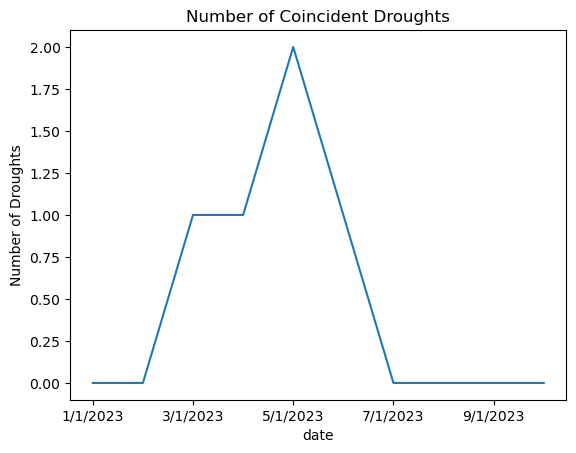

In [37]:
ax = rad_df['coincident_droughts'].plot()
plt.title('Number of Coincident Droughts')
plt.savefig(f'/home/548/cd3022/figs/regional_coincident_drought_timeline_{start_date}_{num_days}_days')
plt.ylabel('Number of Droughts')
plt.show()

In [7]:
# Find consecutive droughts days, count length of drought and number of unique droughts

# makes a dict of regional dicts
# each regional dict contains a dict for how many times that region experienced a drought of different legnths

# Generate 2D array same as "is_drought_day", but cumulative days increment by 1
# Create an array for cumulative drought counts
cumulative_droughts = np.zeros_like(np.stack(is_drought_day), dtype=int)

# Iterate through the time axis while resetting counts on drought breaks
cumulative_droughts[0] = drought_stack[0]  # Initialize the first time step
for t in range(1, drought_stack.shape[0]):
    # Increment drought count where drought continues
    cumulative_droughts[t] = (
        (cumulative_droughts[t - 1] + 1) * drought_stack[t]
    )

regional_drought_lengths = {}
for i, region in enumerate(regions):
    drought_lengths = {}
    for j in range(len(cumulative_droughts[:, i])-1):
        if cumulative_droughts[j, i] == 0:
            continue
        if cumulative_droughts[j+1, i] != 0:
            continue
        length = cumulative_droughts[j, i]
        if f'{length}' not in drought_lengths:
            drought_lengths[f'{length}'] = 1
        else:
            drought_lengths[f'{length}'] += 1
    if cumulative_droughts[-1, i] != 0:
        length = cumulative_droughts[-1, i]
        if f'{length}' not in drought_lengths:
            drought_lengths[f'{length}'] = 1
    regional_drought_lengths[region] = drought_lengths
regional_drought_lengths

{'1GSYD': {'1': 1},
 '2GMEL': {'1': 1},
 '3GBRI': {'1': 1},
 '4GADE': {},
 '5GPER': {},
 '6GHOB': {'1': 1},
 '7GDAR': {'1': 1},
 '8ACTE': {}}

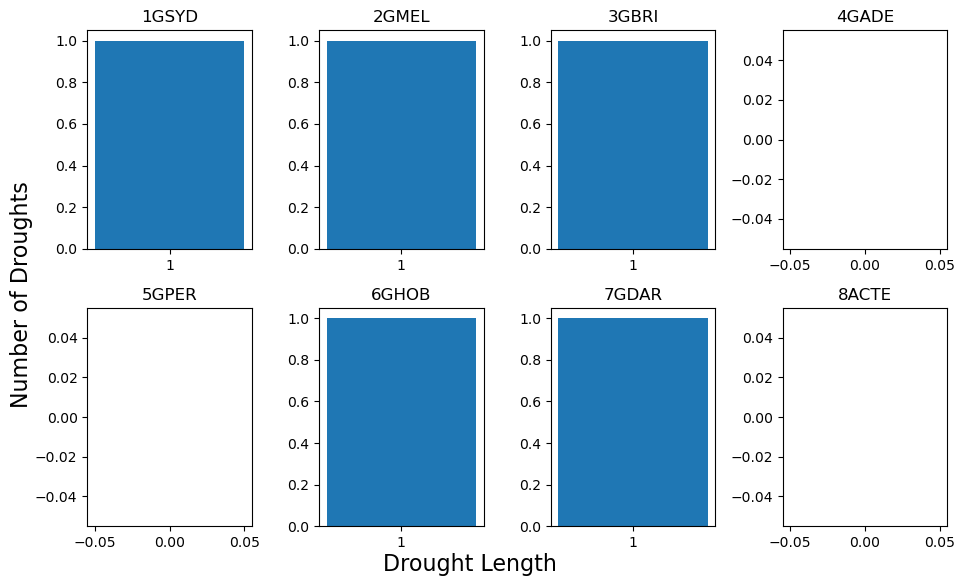

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(10, 6))  # 4 rows and 2 columns of subplots
axes = axes.ravel()

# Plot data for each region
for idx, (region, data) in enumerate(regional_drought_lengths.items()):
    ax = axes[idx]
    ax.bar(data.keys(), data.values())
    ax.set_title(region)
    # ax.set_xlabel('Drought Length')
    # ax.set_ylabel('Number of Droughts')

# Add global x and y labels
fig.text(0.5, 0.04, 'Drought Length', ha='center', fontsize=16)  # x-label
fig.text(0.04, 0.5, 'Number of Droughts', va='center', rotation='vertical', fontsize=16)  # y-label

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.savefig(f'/home/548/cd3022/figs/regional drought histogram_{start_date}_{num_days}_days')
plt.show()

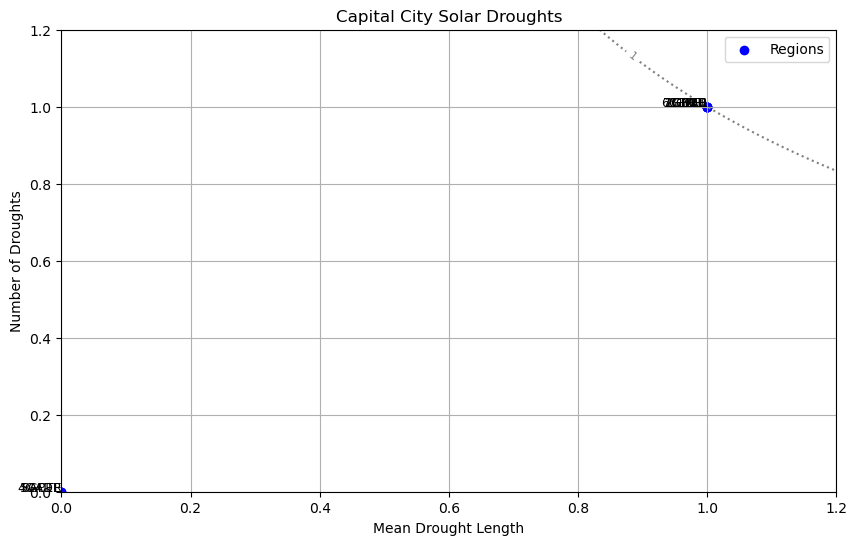

In [9]:
# Produce Figure 4 from Raynaud et al. (2018)
# Make tuple (x,y) where x is the mean drought length in that region,
# and y is the total number of drought days experienced.

raynaud_plot_data = {}
for i, region in enumerate(regional_drought_lengths):
    droughts = regional_drought_lengths[region]
    num_droughts = sum(droughts.values())  # Sum all drought counts
    if num_droughts == 0:
        raynaud_plot_data[region] = (0, 0)
    else:
        raynaud_plot_data[region] = (num_drought_days[i] / num_droughts, num_droughts)

# Extract x and y values for plotting
x_values = [coords[0] for coords in raynaud_plot_data.values()]
y_values = [coords[1] for coords in raynaud_plot_data.values()]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, color="blue", label="Regions")

# Annotate points with region names
for region, (x, y) in raynaud_plot_data.items():
    plt.text(x, y, region, fontsize=9, ha="right")

# Add contours of constant total drought days (x * y)
x = np.linspace(0, max(x_values) * 1.2, 100)
y = np.linspace(0, max(y_values) * 1.2, 100)
X, Y = np.meshgrid(x, y)
Z = X * Y  # Total drought days

# Contour levels
contour_levels = [1, 2, 3, 4, 5, 6, 7, 8]  # Adjust based on your data
contours = plt.contour(X, Y, Z, levels=contour_levels, colors='gray', linestyles='dotted')
plt.clabel(contours, inline=True, fontsize=8, fmt='%d')  # Label contours

# Final plot customizations
plt.xlabel("Mean Drought Length")
plt.ylabel("Number of Droughts")
plt.title("Capital City Solar Droughts")
plt.grid(True)
plt.legend()
plt.savefig(f'/home/548/cd3022/figs/Raynaud et al plot_{start_date}_{num_days}_days')
plt.show()